Acknowledgements for this practice notebook to the [Practical_RL](https://github.com/yandexdataschool/Practical_RL) course team.

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week05_explore/action_rewards.npy
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week05_explore/all_states.npy

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../1-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../2-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../3-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselected package xfonts-encodings.
Preparing to unpack .../4-xfonts-encodings_1%3a1.0.5-0ubuntu2_all.deb ...
Unpacking xfonts-encodings (1:1.0.5-0ubuntu2) ...
Selecting previously unselected package xfonts-util

In [2]:
from abc import ABCMeta, abstractmethod, abstractproperty
import enum

import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import pandas

import matplotlib.pyplot as plt
%matplotlib inline

## Homework Part 1. Bernoulli Bandit (3 points)

We are going to implement several exploration strategies for simplest problem - bernoulli bandit.

The bandit has $K$ actions. Action produce 1.0 reward $r$ with probability $0 \le \theta_k \le 1$ which is unknown to agent, but fixed over time. Agent's objective is to minimize regret over fixed number $T$ of action selections:

$$\rho = T\theta^* - \sum_{t=1}^T r_t$$

Where $\theta^* = \max_k\{\theta_k\}$

**Real-world analogy:**

Clinical trials - we have $K$ pills and $T$ ill patient. After taking pill, patient is cured with probability $\theta_k$. Task is to find most efficient pill.

A research on clinical trials - https://arxiv.org/pdf/1507.08025.pdf

In [3]:
class BernoulliBandit:
    def __init__(self, n_actions=5):
        self._probs = np.random.random(n_actions)

    @property
    def action_count(self):
        return len(self._probs)

    def pull(self, action):
        if np.any(np.random.random() > self._probs[action]):
            return 0.0
        return 1.0

    def optimal_reward(self):
        """ Used for regret calculation
        """
        return np.max(self._probs)

    def step(self):
        """ Used in nonstationary version
        """
        pass

    def reset(self):
        """ Used in nonstationary version
        """

In [4]:
class AbstractAgent(metaclass=ABCMeta):
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0

    @abstractmethod
    def get_action(self):
        """
        Get current best action
        :rtype: int
        """
        pass

    def update(self, action, reward):
        """
        Observe reward from action and update agent's internal parameters
        :type action: int
        :type reward: int
        """
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1

    @property
    def name(self):
        return self.__class__.__name__


class RandomAgent(AbstractAgent):
    def get_action(self):
        return np.random.randint(0, len(self._successes))

Суть многорукого бандита можно описать следующим образом: пусть у нас есть черный ящик, на котором есть N кнопок. При нажатии на каждую кнопку пользователь с некоторой вероятностью получает награду (для каждой кнопки распределение вероятности выдачи награды свое). Однако пользователю эти распределения неизвестны. Наша задача как можно быстрее научиться получать много награды путем нажимания на кнопки.

В данном задании бандит называется бернулевским, так как награда, получаемая при исполнении действия строго детерминирована двумя значениями -- 0 или 1.

### Epsilon-greedy agent

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\hat\theta_k \leftarrow \alpha_k / (\alpha_k + \beta_k)$

&nbsp;&nbsp; **end for**

&nbsp;&nbsp; $x_t \leftarrow argmax_{k}\hat\theta$ with probability $1 - \epsilon$ or random action with probability $\epsilon$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**

Implement the algorithm above in the cell below:

In [5]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon=0.01):
        self._epsilon = epsilon

    '''
    По своей сути alpha_k -- количество раз, когда выбор k-го действия привел к получению reward
    beta_k -- количество раз, когда выбор k-го действия НЕ привел к получению reward.
    Значит в данной реализации в качестве alpha и beta выступают self._successes и self._failures соотвественно.
    '''
    def get_action(self):
      theta = []
      for i in range(len(self._successes)):
        if self._successes[i] != 0 and self._failures[i] != 0:
          theta.append(self._successes[i]/(self._successes[i]+self._failures[i]))
        else:
          theta.append(np.random.random())

      # считаем вероятность для eps-greed стратегии, назовем ее p
      p = np.random.random()
      if p <= self._epsilon:
        # выбираем случайное действие (выбираем номер случайного действия из доступных))
        action = np.random.randint(len(self._successes))
      else:
        # выбираем действие с максимальной theta
        action = np.argmax(np.array(theta))
      return action

    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon)

### UCB Agent
Epsilon-greedy strategy have no preference for actions. It would be better to select among actions that are uncertain or have potential to be optimal. One can come up with idea of index for each action that represents optimality and uncertainty at the same time. One efficient way to do it is to use UCB1 algorithm:

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w_k \leftarrow \alpha_k / (\alpha_k + \beta_k) + \sqrt{2\log(t) \ / \ (\alpha_k + \beta_k)}$

&nbsp;&nbsp; **end for**

&nbsp;&nbsp; **end for**
 $x_t \leftarrow argmax_{k}w$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**

__Note:__ in practice, one can multiply $\sqrt{2\log(t) \ / \ (\alpha_k + \beta_k)}$ by some tunable parameter to regulate agent's optimism and wilingness to abandon non-promising actions.

More versions and optimality analysis - https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf

In [6]:
class UCBAgent(AbstractAgent):
    '''
    t -- сколько раз произошел выбор действия с начала работы агента.
    Значит в данной реализации за эту величину отвечает self._total_pulls
    '''
    def get_action(self):
      w = []
      for i in range(len(self._successes)):
        if self._successes[i] != 0 and self._failures[i] != 0 and self._total_pulls != 0:
          w.append(self._successes[i]/(self._successes[i]+self._failures[i]) +  np.sqrt(2*np.log10(self._total_pulls)/(self._successes[i]+self._failures[i])))
        else:
          w.append(np.random.random())

      return np.argmax(np.array(w))

### Thompson sampling

UCB1 algorithm does not take into account actual distribution of rewards. If we know the distribution - we can do much better by using Thompson sampling:

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Sample $\hat\theta_k \sim beta(\alpha_k, \beta_k)$

&nbsp;&nbsp; **end for**

&nbsp;&nbsp; $x_t \leftarrow argmax_{k}\hat\theta$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**


More on Thompson Sampling:
https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf

In [7]:
class ThompsonSamplingAgent(AbstractAgent):
    def get_action(self):
      theta = []
      for i in range(len(self._successes)):
        if self._successes[i] > 0 and self._failures[i] > 0:
          theta.append(np.random.beta(self._successes[i], self._failures[i]))
        else:
          theta.append(np.random.random())
      return np.argmax(np.array(theta))

In [8]:
from collections import OrderedDict

def get_regret(env, agents, n_steps=5000, n_trials=50):
    scores = OrderedDict({
        agent.name: [0.0 for step in range(n_steps)] for agent in agents
    })

    for trial in range(n_trials):
        env.reset()

        for a in agents:
            a.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()

            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward

            env.step()  # change bandit's state if it is unstationary

    for agent in agents:
        scores[agent.name] = np.cumsum(scores[agent.name]) / n_trials

    return scores

def plot_regret(agents, scores):
    for agent in agents:
        plt.plot(scores[agent.name])

    plt.legend([agent.name for agent in agents])

    plt.ylabel("regret")
    plt.xlabel("steps")

    plt.show()

На данных граиках по оси ординат отложен regret, то есть накопленное отклонение оптимальной награды от той, которую мы получили реально. Таким образом, интуитивно, чем ниже эта величина у агента в любой момент времени, тем лучше. Для начала посмотрим, что будет, если запустить в среду рандомного агента (то есть, агента, который выбирает действия рандомно) и затем агентов, которые имеют описанные выше стратегии выбора действия.

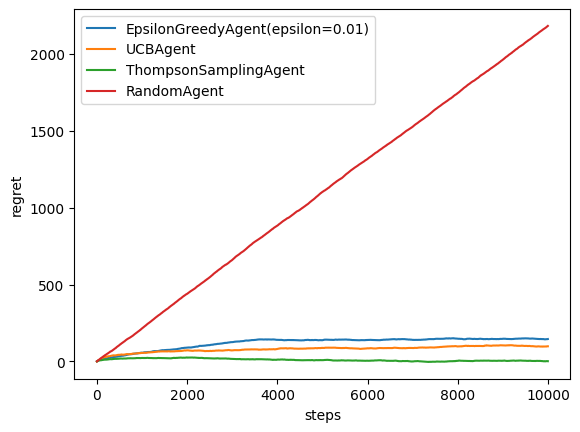

In [9]:
# Uncomment agents
agents = [
        EpsilonGreedyAgent(),
        UCBAgent(),
        ThompsonSamplingAgent(),
        RandomAgent()
]

regret = get_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)
plot_regret(agents, regret)

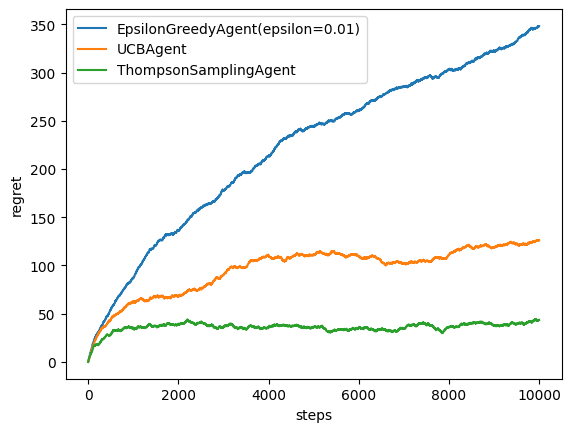

In [11]:
# Uncomment agents
agents = [
        EpsilonGreedyAgent(),
        UCBAgent(),
        ThompsonSamplingAgent()
]

regret = get_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)
plot_regret(agents, regret)

# [Optional] Homework (Bonus Part). Gittins index (3 points).

Bernoulli bandit problem has an optimal solution - Gittins index algorithm. Implement finite horizon version of the algorithm and demonstrate it's performance with experiments. Some articles:
- Wikipedia article - https://en.wikipedia.org/wiki/Gittins_index
- Different algorithms for index computation - http://www.ece.mcgill.ca/~amahaj1/projects/bandits/book/2013-bandit-computations.pdf (see "Bernoulli" section)
    

# Homework Part 2: Nonstationary Bernoulli bandit (4 points)

What if success probabilities change over time? Here is an example of such bandit:

In [12]:
class DriftingBandit(BernoulliBandit):
    def __init__(self, n_actions=5, gamma=0.01):
        """
        Idea from https://github.com/iosband/ts_tutorial
        """
        super().__init__(n_actions)

        self._gamma = gamma

        self._successes = None
        self._failures = None
        self._steps = 0

        self.reset()

    def reset(self):
        self._successes = np.zeros(self.action_count) + 1.0
        self._failures = np.zeros(self.action_count) + 1.0
        self._steps = 0

    def step(self):
        action = np.random.randint(self.action_count)
        reward = self.pull(action)
        self._step(action, reward)

    def _step(self, action, reward):
        self._successes = self._successes * (1 - self._gamma) + self._gamma
        self._failures = self._failures * (1 - self._gamma) + self._gamma
        self._steps += 1

        self._successes[action] += reward
        self._failures[action] += 1.0 - reward

        self._probs = np.random.beta(self._successes, self._failures)

And a picture how it's reward probabilities change over time

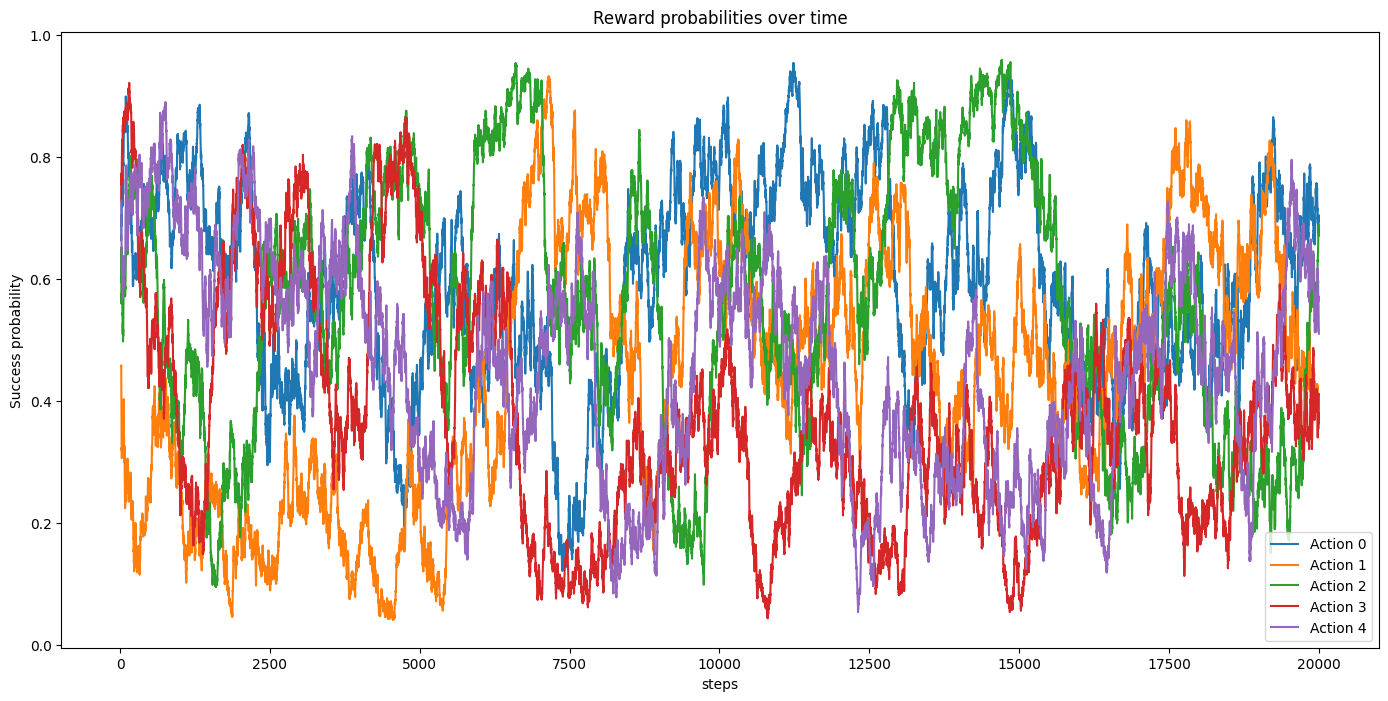

In [13]:
drifting_env = DriftingBandit(n_actions=5)

drifting_probs = []
for i in range(20000):
    drifting_env.step()
    drifting_probs.append(drifting_env._probs)

plt.figure(figsize=(17, 8))
plt.plot(pandas.DataFrame(drifting_probs).rolling(window=20).mean())

plt.xlabel("steps")
plt.ylabel("Success probability")
plt.title("Reward probabilities over time")
plt.legend(["Action {}".format(i) for i in range(drifting_env.action_count)])
plt.show()

Ситуация усложнилась. В этот раз распределения вероятности выдачи награды при нажатии на каждую кнопку меняется со временем.
Естественная стратегия решения такой задачи -- не доверять знаниям об исследовании среды, накопленным за предыдущие попытки. В данной реализации попробуем уменьшать со временем характеристики $\alpha$ и $\beta$ каждого действия по следующему закону:
$$
\alpha_k = (1 - \gamma) \alpha_k
$$
$$
\beta_k = (1 - \gamma) \beta_k
$$
если действие НЕ совпадает с выбранным
$$
\alpha_k = (1 - \gamma) \alpha_k + r_k
$$
$$
\beta_k = (1 - \gamma) \beta_k + (1 - r_k)
$$
если действие совпадает с выбранным.

In [14]:
class DriftingAgentThompson(ThompsonSamplingAgent):
  def __init__(self, gamma=0.5):
    self._gamma = gamma
    super().__init__()

  def update(self, action, reward):
    self._total_pulls += 1

    for a in range(len(self._successes)):
      if a != action:
        self._successes[a] -= self._successes[a] * self._gamma
        self._failures[a] -= self._failures[a] * self._gamma
      else:
        self._successes[a] += reward - self._successes[a] * self._gamma
        self._failures[a] += 1 - reward - self._failures[a] * self._gamma

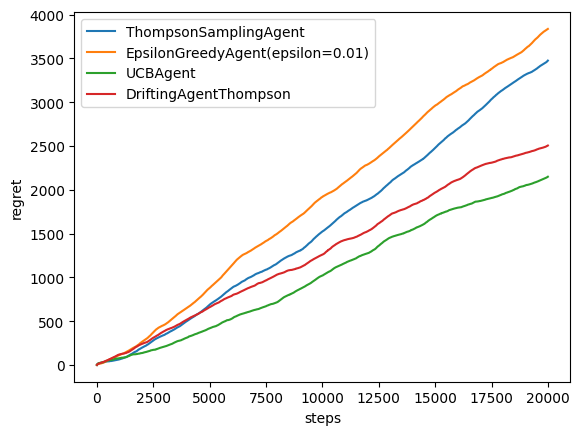

In [15]:
drifting_agents = [
    ThompsonSamplingAgent(),
    EpsilonGreedyAgent(),
    UCBAgent(),
    DriftingAgentThompson()
]

regret = get_regret(DriftingBandit(), drifting_agents, n_steps=20000, n_trials=10)
plot_regret(drifting_agents, regret)

Как видно, данная стратегия дала некоторые улучшения, но все еще не идеальна. Попробуем другой подход. Для расчета параметров $\alpha_k$ и $\beta_k$ учитывать не всю историю действий, а только определенное количество последних шагов (history size -- это будет гиперпараметр).
Однако, еще более хорошим подходом будет не отбрасывать остальную часть истории вообще, а лишь давать ей меньший приоритет. Используем для этого еще один гиперпараметр $\gamma \in [0, 1]$. Чем больше параметр $\gamma$, тем больший приоритет мы отдаем предпочтение последним history_size шагам.
Таким образом, мы заводим 2 очереди размера history_size, в которые на каждом шаге складываем массивы $\alpha$ и $\beta$.

In [16]:
from copy import copy

class Queue:
  def __init__(self, size):
    self._size = size
    self._data = []

  def get_size(self):
    return len(self._data)

  def get_head(self):
    return self._data[0]

  def get_tail(self):
    return self._data[-1]

  def pop(self):
    self._data.pop(0)

  def push(self, x):
    if len(self._data) < self._size:
      self._data.append(copy(x))
    else:
      self.pop()
      self._data.append(copy(x))
      assert(len(self._data) == self._size)

  def clear(self):
    self._data = []

  def get_data(self):
    return self._data

Your task is to invent an agent that will have better regret than stationary agents from above.

In [17]:
class DriftingAgent(AbstractAgent):
  def __init__(self, history_size=90, gamma=0.9):
    self._history_size = history_size
    self._queue_alpha = Queue(history_size)
    self._queue_beta = Queue(history_size)
    self._gamma = gamma
    super().__init__()

  def get_action(self):
    if self._queue_alpha.get_size() == 0 or self._queue_beta.get_size() == 0:
      alpha = self._successes
      beta = self._failures
    else:
      alpha = self._gamma*(self._successes - self._queue_alpha.get_head()) + (1 - self._gamma)*self._queue_alpha.get_head()
      beta = self._gamma*(self._failures - self._queue_beta.get_head()) + (1 - self._gamma)*self._queue_beta.get_head()

    if (self._successes == np.zeros(len(self._successes))).all() and (self._failures == np.zeros(len(self._failures))).all():
      alpha = self._successes
      beta = self._failures
      self._queue_alpha.clear()
      self._queue_beta.clear()

    w = []
    for i in range(len(alpha)):
      if alpha[i] != 0 and beta[i] != 0 and self._total_pulls != 0:
        w.append(alpha[i]/(alpha[i]+beta[i]) +  np.sqrt(2*np.log10(self._total_pulls)/(alpha[i]+beta[i])))
      else:
        w.append(np.random.random())

    return np.argmax(np.array(w))

  def update(self, action, reward):
    self._total_pulls += 1

    self._queue_alpha.push(self._successes)
    self._queue_beta.push(self._failures)

    if reward == 1:
        self._successes[action] += 1
    else:
        self._failures[action] += 1

  @property
  def name(self):
      return self.__class__.__name__ + f"(history_size={self._history_size} gamma={self._gamma})"

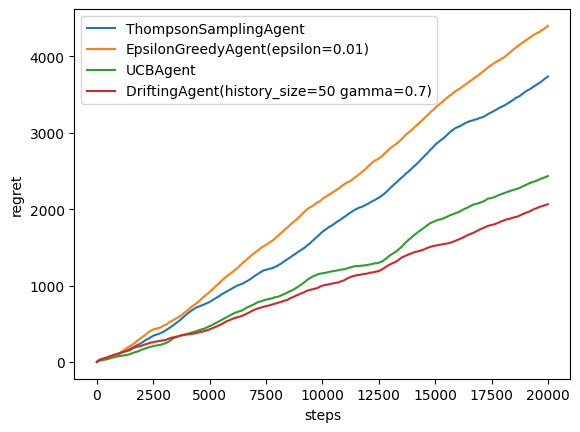

In [20]:
drifting_agents = [
    ThompsonSamplingAgent(),
    EpsilonGreedyAgent(),
    UCBAgent(),
    DriftingAgent(history_size=50, gamma=0.7)
]

regret = get_regret(DriftingBandit(), drifting_agents, n_steps=20000, n_trials=10)
plot_regret(drifting_agents, regret)